### UMAP plots for OOD detectioon

In [2]:
import sys
import os

import pandas as pd
import numpy as np

ROOT_PATH = '/home/karina/ehr_ood_detection/'
sys.path.append(ROOT_PATH)

TABLES_DIR = os.path.join(ROOT_PATH, "data/novelty_tables")
DATA_ORIGIN = "VUmc"

In [7]:
# STD
import os
from typing import List, Optional

import numpy as np
import pandas as pd
from sklearn import pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import umap.umap_ as umap

from src.utils.datahandler import load_data_from_origin, DataHandler


# TABLES_DIR = 'data/novelty_tables'


def _plot_umap_axis(ax, emb, method_outliers, column):
    colors = ['lightgray' if not x else 'red' for x in method_outliers]
    sizes = [0.5 if not x else 3 for x in method_outliers]
    ax.scatter(emb[:, 0], emb[:, 1], c=colors, s=sizes)
    ax.set_title(column)


def plot_umap(data_origin: str,
              outliers_filename: str = "outliers.csv",
              tables_dir: str = TABLES_DIR):
    """

    Parameters
    ----------
    data_origin: str
        Name of the dataset.
    outliers_filename: str
        Name of the file where the boolean outlier table is stored.
    tables_dir: str
        Directory to the novelty tables where outliers filename is stored.

    Returns
    -------

    """
    # Load and process data for embedding
    data_loader = load_data_from_origin(data_origin)
    dh = DataHandler(**data_loader)
    _, test_data, _ = dh.load_data_splits()
    test_data = test_data[dh.load_feature_names()]

    # Load the table of outliers for each model and metric
    outliers_path = os.path.join(tables_dir, data_origin, "novelty_scores", outliers_filename)
    outliers = pd.read_csv(outliers_path, index_col=0)

    test_data = test_data.sort_index(axis=0)
    outliers = outliers.sort_index(axis=0)
    assert (outliers.index == test_data.index).all()

    pipe = pipeline.Pipeline(
        [("scaler", StandardScaler()), ("imputer", SimpleImputer())]
    )
    test_data = pipe.fit_transform(test_data)

    # Fit the UMAP function on the test data
    fitter = umap.UMAP(20)
    emb = fitter.fit_transform(test_data)

    columns = list(outliers.columns)
    columns.remove("Number of models")

    # Plot the figure
    fig = plt.figure(figsize=(10, 8))
    n_cols, n_rows = 5, 5

    fig = plt.figure(figsize=(20, 20))
    for i, column in enumerate(sorted(columns)):
        method_outliers = outliers[column].tolist()
        ax = fig.add_subplot(n_rows, n_cols, i + 1)
        _plot_umap_axis(ax, emb, method_outliers, column)

    # Plot union
    ax = fig.add_subplot(n_rows, n_cols, len(columns) + 1)
    _plot_umap_axis(ax, emb, outliers["Number of models"], "Union")

    # Plot intersection
    ax = fig.add_subplot(n_rows, n_cols, len(columns) + 2)
    _plot_umap_axis(ax, emb, outliers["Number of models"] > 10, "Intersection (> 10 models)")

    plt.show()

<Figure size 720x576 with 0 Axes>

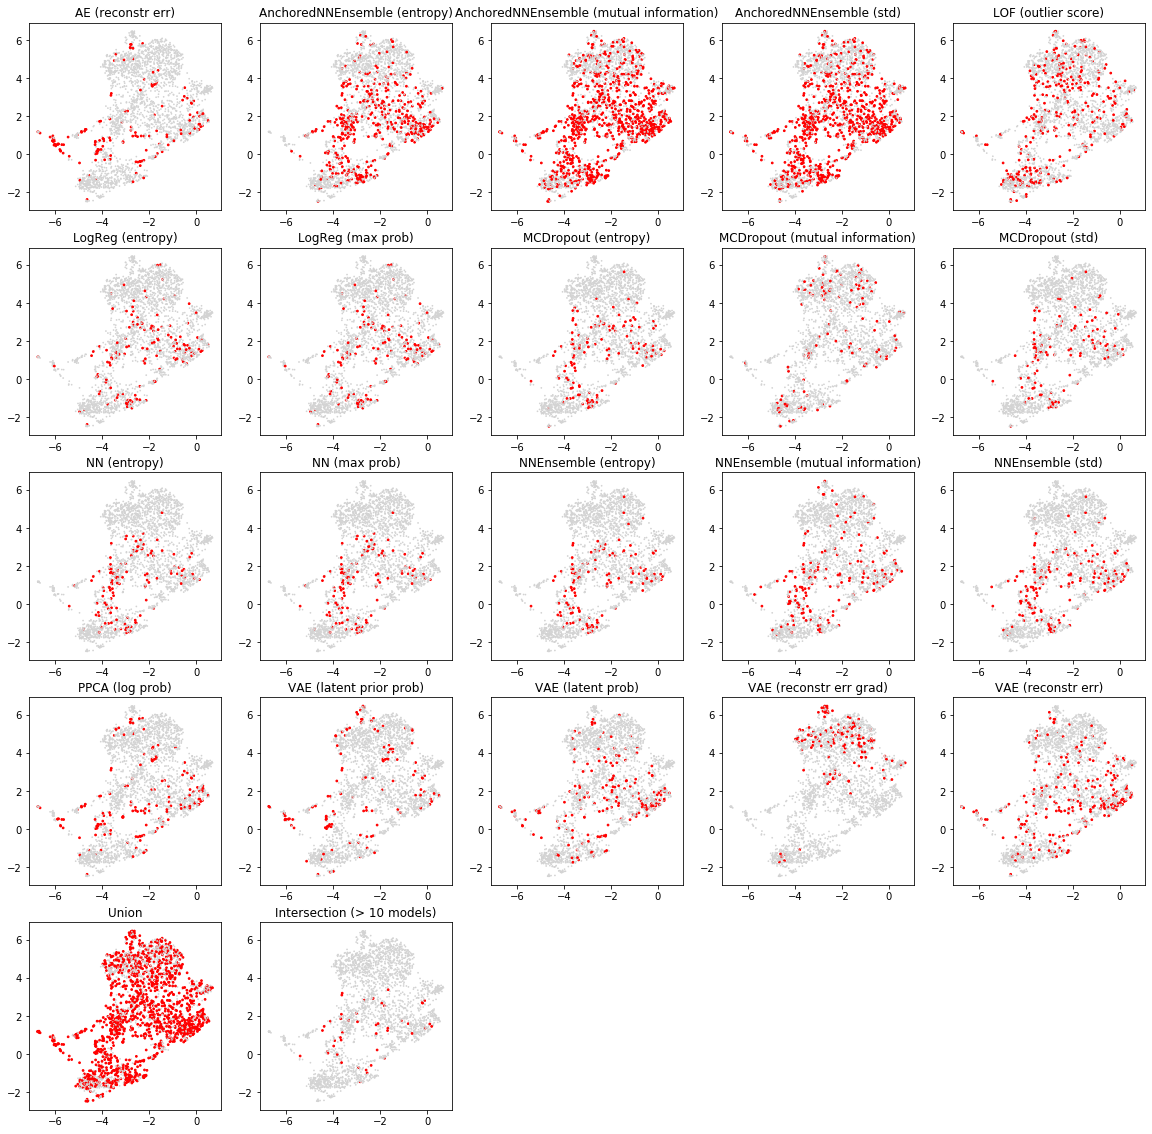

In [8]:
plot_umap(data_origin="VUmc", 
         outliers_filename = "outliers.csv")